In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
import warnings
from sklearn.impute import SimpleImputer
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [2]:
#Read the data from the csv file
data = pd.read_csv('Diabetes Dataset.csv')

#Display the data out
display(data)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
#Display a pairplot
# plot = sns.pairplot(data, hue = 'Outcome')
# plt.show()

<Axes: >

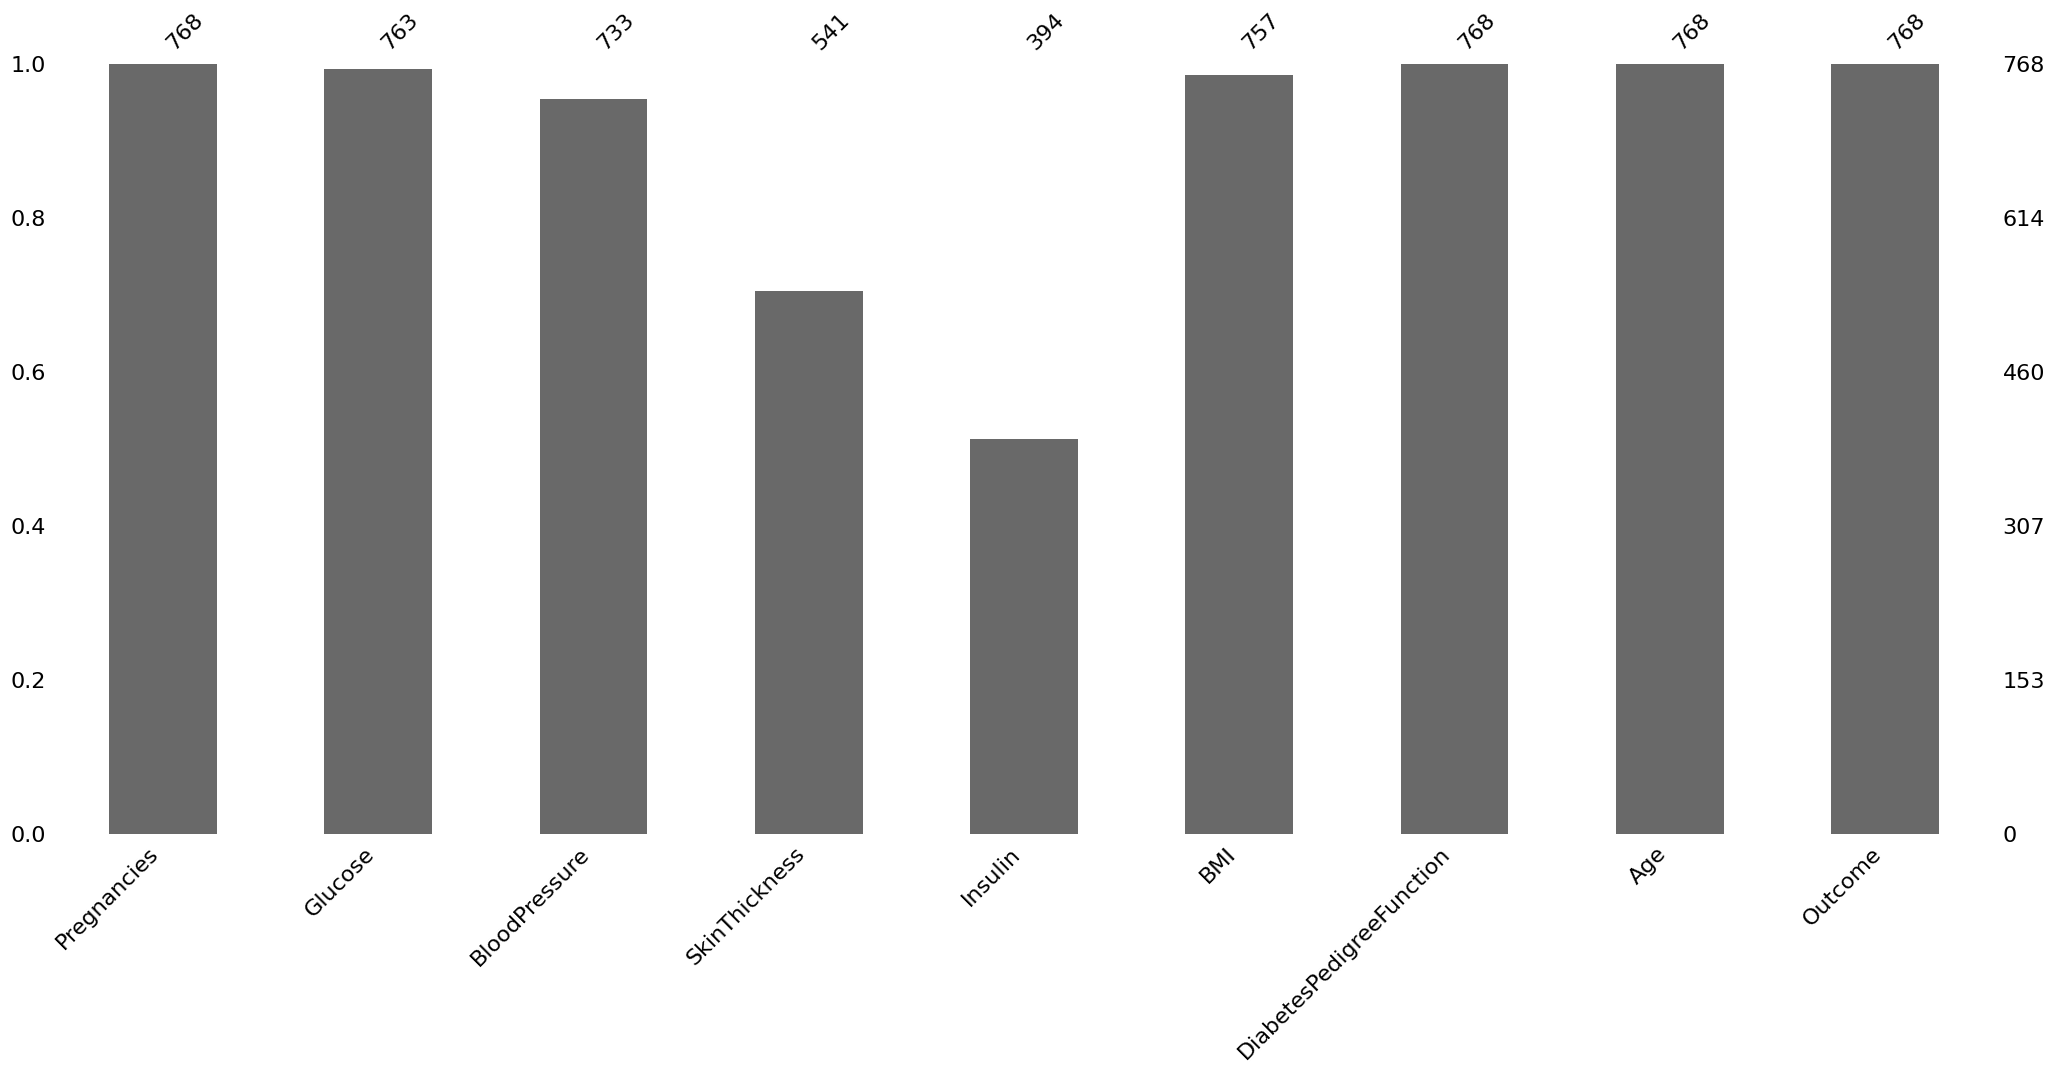

In [4]:
#Display out the number data is not 0 values or null for selected columns
column = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']
data[column] = data[column].replace(0, np.nan)
plot = msno.bar(data)
plot

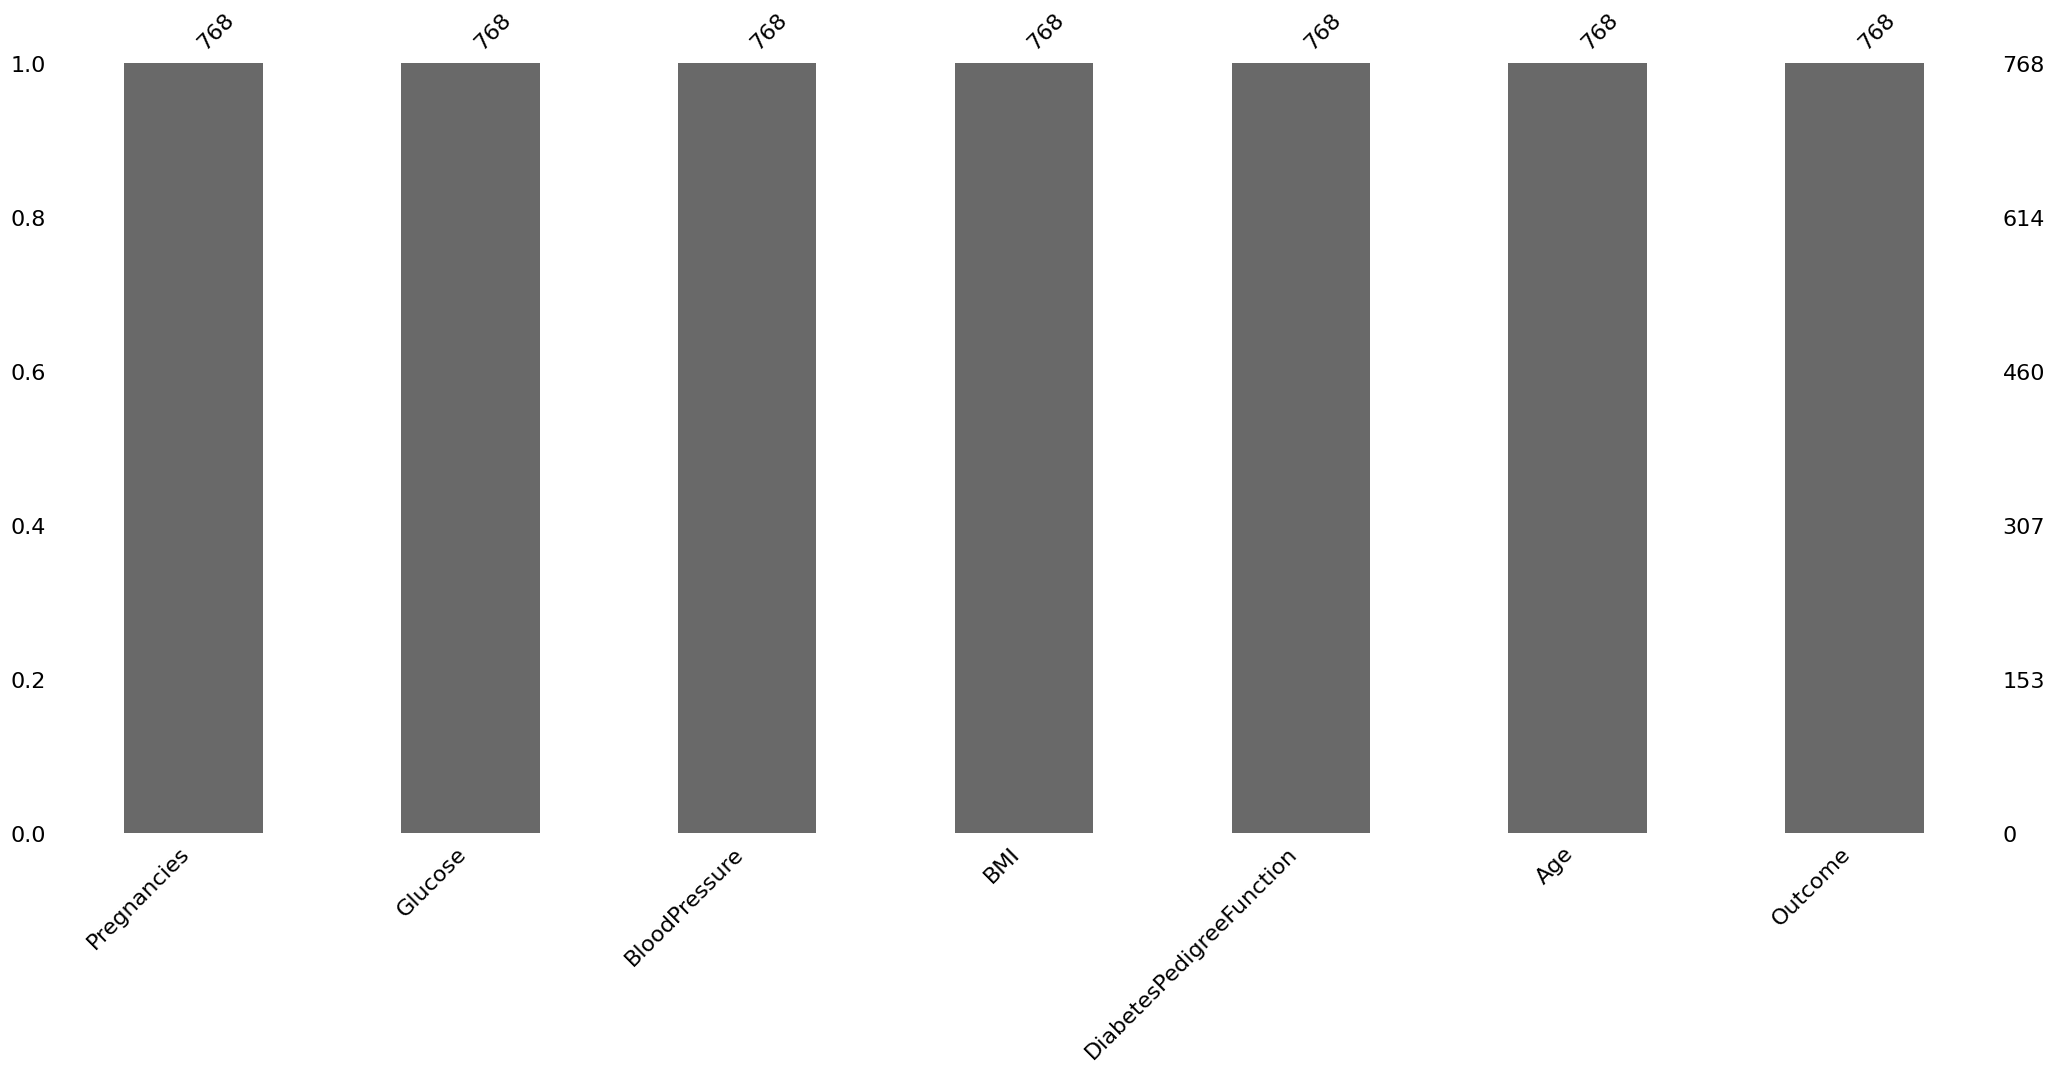

In [5]:
#Start to preprocess the data
#Since the SkinThinkness and Insulin having a lot of missing data, drop the columns

#Set the threshold that having missing value more than 10% of the data
threshold = 0.9 * len(data)
#Drop the column according to the threshold set
data = data.dropna(thresh = threshold, axis = 1)

#Replace the missing value with the mean of the sum of data for remaining columns
imr = SimpleImputer(missing_values = np.nan, strategy = "mean")
columns = ["Glucose", "BloodPressure", "BMI"]
data[columns] = imr.fit_transform(data[columns])
plot = msno.bar(data)

In [6]:
#drop the target features, in this model, our target will be the Outcome column
target_column = ['Outcome']
X = data.drop(target_column, axis = 1)
y = data[target_column]

print('Below is the Features column:\n')
display(X)
print('Below is the Target column:\n')
display(y)

Below is the Features column:



,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,33.6,0.627,50
1,1,85.0,66.0,26.6,0.351,31
2,8,183.0,64.0,23.3,0.672,32
3,1,89.0,66.0,28.1,0.167,21
4,0,137.0,40.0,43.1,2.288,33
...,...,...,...,...,...,...
763,10,101.0,76.0,32.9,0.171,63
764,2,122.0,70.0,36.8,0.340,27
765,5,121.0,72.0,26.2,0.245,30
766,1,126.0,60.0,30.1,0.349,47


Below is the Target column:



,Outcome
0,1
1,0
2,1
3,0
4,1
...,...
763,0
764,0
765,0
766,1


In [7]:
from sklearn.model_selection import train_test_split

#Start to split the data for training and testing
random = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = random, stratify = y)

#Just print out the shape to make sure they are the same
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (537, 6) (537, 1)
Testing data shape: (231, 6) (231, 1)


In [8]:
#Use Decision Tree Regressor for Model Training
logistic_regressor = LogisticRegression(random_state = random, max_iter = 1000)
logistic_regressor.fit(X_train, y_train.values.ravel())

#Start to predict the data
y_pred_logistic_regression = logistic_regressor.predict(X_test)

report = classification_report(y_test, y_pred_logistic_regression)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.84      0.80       150
           1       0.64      0.53      0.58        81

    accuracy                           0.73       231
   macro avg       0.71      0.69      0.69       231
weighted avg       0.72      0.73      0.72       231



In [9]:
#Hyperparameter tuning for Logistics Regression

warnings.filterwarnings('ignore', category = ConvergenceWarning)

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']
}

#Create the logistic regression model
model = LogisticRegression(random_state = random, max_iter = 1000)

#Perform grid search with cross-validation
best_score = 0
best_params_lr = None
best_model_lr = None


#Have to remove incompatible solvers from different penalty
for penalty in param_grid['penalty']:
    # Exclude incompatible solvers based on penalty
    compatible_solvers = ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']
    if penalty == 'l1':
        incompatible_solvers = ['lbfgs', 'newton-cg', 'sag'] # Remove lbfgs, newton-cg and sag for 'l2' penalty
        compatible_solvers = [solver for solver in compatible_solvers if solver not in incompatible_solvers]
    elif penalty == 'l2':
        compatible_solvers.remove('liblinear')  #Remove liblinear for 'l2' penalty

    # Create a subset of the param_grid with compatible solvers
    compatible_param_grid = {
        'penalty': [penalty],
        'C': param_grid['C'],
        'solver': compatible_solvers
    }

    grid_search = GridSearchCV(model, compatible_param_grid, cv = 5, scoring = 'accuracy', error_score = 'raise')
    grid_search.fit(X_train, y_train.values.ravel())

    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_params_lr = grid_search.best_params_
        best_model_lr = grid_search.best_estimator_

#Use the best model to predict again
y_pred_tuned_lr = best_model_lr.predict(X_test)

accuracy_lr = accuracy_score(y_test, y_pred_tuned_lr)
report_lr = classification_report(y_test, y_pred_tuned_lr)
labels = [1, 0]
confusion_lr = confusion_matrix(y_test, y_pred_tuned_lr, labels = labels)

print('Best Hyperparameters:', best_params_lr)
print('Accuracy:', accuracy_lr)
print('Classification Report:\n', report_lr)
print('Confusion Matrix:\n', confusion_lr)

Best Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.7316017316017316
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.84      0.80       150
           1       0.64      0.53      0.58        81

    accuracy                           0.73       231
   macro avg       0.71      0.69      0.69       231
weighted avg       0.72      0.73      0.72       231

Confusion Matrix:
 [[ 43  38]
 [ 24 126]]


In [10]:
#User Random Forest Classifier for Model Training
random_forest = RandomForestClassifier(random_state = random)
random_forest.fit(X_train, y_train.values.ravel())

#Start to predict the data
y_pred_random_forest = random_forest.predict(X_test)

report = classification_report(y_test, y_pred_random_forest)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       150
           1       0.68      0.59      0.63        81

    accuracy                           0.76       231
   macro avg       0.73      0.72      0.73       231
weighted avg       0.75      0.76      0.75       231



In [ ]:
#Hyperparameter tuning for Random Forest Classifier

param_grid = {
    'n_estimators': [50, 100, 150, 200],  
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4], 
    'max_features': ['sqrt', 'log2'], 
    'criterion': ['gini', 'entropy'] 
}

#Create the Random Forest model
model = RandomForestClassifier(random_state = random)

#Perform grid search with cross-validation
best_score_rf = 0
best_params_rf = None
best_model_rf = None

grid_search = GridSearchCV(model, param_grid, cv = 5, scoring = 'accuracy', error_score = 'raise')
grid_search.fit(X_train, y_train.values.ravel())

best_score_rf = grid_search.best_score_
best_params_rf = grid_search.best_params_
best_model_rf = grid_search.best_estimator_

#Use the best model to predict again
y_pred_tuned_rf = best_model_lr.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_tuned_lr)
report_rf = classification_report(y_test, y_pred_tuned_lr)
labels = [1, 0]
confusion_rf = confusion_matrix(y_test, y_pred_tuned_lr, labels = labels)

print('Best Hyperparameters:', best_params_rf)
print('Accuracy:', accuracy_rf)
print('Classification Report:\n', report_rf)
print('Confusion Matrix:\n', confusion_rf)

In [ ]:
import joblib

#Exporting model
#For the best Logistic Regression Model
joblib.dump(best_model_lr, 'Logistic Regression Model.pkl')

#For the best Random Forest Model
joblib.dump(best_model_rf, 'Random Forest Model.pkl')

In [ ]:
# Sample data for model testing
input_data = [[3, 128, 100, 35, 1.3, 25]]
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age']

X_input = pd.DataFrame(input_data, columns = features)

def getResult(result):
    if(result == 1):
        return 'Positive'
    else:
        return 'Negative'
        
lr_predict = best_model_lr.predict(X_input)
rf_predict = best_model_rf.predict(X_input)

print(f'The prediction from Logistic Regression is {getResult(lr_predict)}')
print(f'The prediction from Random Forest is {getResult(rf_predict)}')